In [53]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

# !pip install matplotlib pandas
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
import seaborn as sns



ModuleNotFoundError: No module named 'torch'

Australia
DatetimeIndex(['2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
               '2019-01-01', '2020-01-01',
               ...
               '2012-12-01', '2013-12-01', '2014-12-01', '2015-12-01',
               '2016-12-01', '2017-12-01', '2018-12-01', '2019-12-01',
               '2020-12-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Date', length=132, freq=None)
New South Wales
DatetimeIndex(['2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
               '2019-01-01', '2020-01-01',
               ...
               '2012-12-01', '2013-12-01', '2014-12-01', '2015-12-01',
               '2016-12-01', '2017-12-01', '2018-12-01', '2019-12-01',
               '2020-12-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Date', length=132, freq=None)
Northern Territory
DatetimeIndex(['2011-01-01'

/tmp/ipykernel_33773/2016821902.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str))
/tmp/ipykernel_33773/2016821902.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str))
/tmp/ipykernel_33773/2016821902.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str))
/tmp/ipykernel_33773/2016821902.py:17: UserWarning: Cou

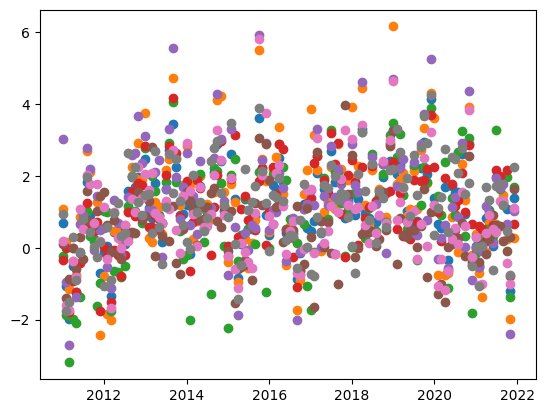

In [193]:
enviro_csv = dict( temp='Enviromental/temp_max_anomaly_c.csv', rainfall='Enviromental/total_rainfall_mm.csv', water_trades= 'Enviromental/water_trades_2011_2021.csv',water_usage= 'Enviromental/water_usage_region_year.csv')
df = pd.read_csv(enviro_csv['temp'], index_col=False)
# remove Unnamed: 0

df = df.drop(columns=['Unnamed: 0'])
# set index to be Year
df.set_index('Year', inplace=True)
# group by region label
# ['Region label']
df = df.groupby('Region label')

for  region, data in df:
    print(region)
    data.drop(columns='Region label', inplace=True)
    data['Year'] = data.index
    data = data.melt(id_vars=['Year'], var_name='Month', value_name='Temperature')
    data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str))
    data.set_index( ['Date'], inplace=True)
    print(data.index)
    # turn off lines
    plt.plot(data.index, data['Temperature'], label=region, linestyle='None', marker='o')

plt.show()



In [129]:
df.head()


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Region label
0,2011,0.70,-1.06,-1.98,-0.51,-1.22,-0.16,0.72,1.82,0.91,0.20,0.18,-0.69,Australia
1,2012,-0.13,0.04,-1.35,0.45,0.39,-0.22,0.11,1.59,1.97,1.69,1.96,1.37,Australia
2,2013,2.47,1.10,0.84,1.79,0.92,0.16,1.64,2.72,3.45,2.25,0.92,0.94,Australia
3,2014,1.18,-0.18,1.24,1.05,1.71,0.54,1.00,0.79,2.10,2.89,2.41,1.02,Australia
4,2015,-0.24,2.60,1.35,-0.84,0.11,1.35,0.52,0.79,0.88,3.61,2.21,0.92,Australia
11,2011,1.08,0.17,-1.16,-0.37,-0.76,0.85,0.63,2.70,2.10,0.23,1.27,-2.44,New South Wales
12,2012,-0.79,-1.83,-2.00,0.47,0.49,0.22,0.62,1.03,2.23,1.93,2.92,1.91,New South Wales
13,2013,3.75,0.26,0.16,1.28,1.14,0.37,2.16,2.47,4.73,2.49,1.18,1.75,New South Wales
14,2014,2.83,1.73,0.25,0.73,1.99,0.79,1.21,0.81,1.55,4.10,4.21,1.54,New South Wales
15,2015,-0.41,1.78,1.28,-0.96,0.16,0.23,-0.55,0.14,0.77,5.51,2.46,1.86,New South Wales


NameError: name 'plt' is not defined

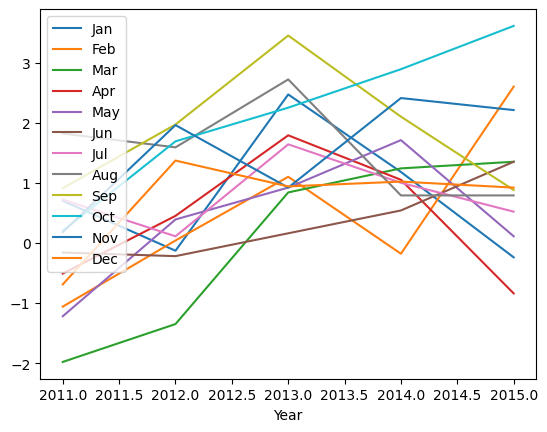

In [102]:
# https://drive.google.com/drive/folders/1Q1qfIj1odObfNIb6dPI8sTzVJ02fveno
# There are two folders with csv datasets in them (Environmental and Governance)
#
import pandas as pd
df = pd.read_csv('Enviromental/water_trades_2011_2021.csv', header = 0).dropna()

df


,resource_type,origin_state,origin_water_system,origin_trading_zone_or_WRPA,dest_state,dest_water_system,dest_trading_zone_or_WRPA,unit_of_measure,quantity_traded,net_price,price_per_ML,date_of_approval,regulated_unregulated,drainage_division,murray_darling_basin_region
1,Groundwater,New South Wales,Lachlan Alluvium (GW10),Lower Lachlan Groundwater Source,New South Wales,Lachlan Alluvium (GW10),Lower Lachlan Groundwater Source,ML,300.0,0,0.0,27-05-2019,unregulated,Murray–Darling Basin,MDB Groundwater
2,Groundwater,New South Wales,Lachlan Alluvium (GW10),Upper Lachlan Alluvial Groundwater Source / Up...,New South Wales,Lachlan Alluvium (GW10),Upper Lachlan Alluvial Groundwater Source / Up...,ML,240.0,0,0.0,27-05-2019,unregulated,Murray–Darling Basin,MDB Groundwater
3,Groundwater,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,ML,45.0,45,1.0,24-05-2019,unregulated,Murray–Darling Basin,MDB Groundwater
4,Groundwater,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,ML,7.7,0,0.0,27-05-2019,unregulated,Murray–Darling Basin,MDB Groundwater
5,Groundwater,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,New South Wales,Murray Alluvium (GW8),Lower Murray Groundwater Source,ML,10.3,0,0.0,27-05-2019,unregulated,Murray–Darling Basin,MDB Groundwater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34298,Surface water,Victoria,VIC Murray (SS2),6 VIC Murray - Dart to Barmah,Victoria,VIC Murray (SS2),7 VIC Murray - Barmah to SA,ML,2.2,0,0.0,27-10-2019,regulated,Murray–Darling Basin,Southern MDB
34299,Surface water,Victoria,VIC Murray (SS2),6 VIC Murray - Dart to Barmah,Victoria,VIC Murray (SS2),7 VIC Murray - Barmah to SA,ML,2.5,0,0.0,27-10-2019,regulated,Murray–Darling Basin,Southern MDB
34300,Surface water,Victoria,VIC Murray (SS2),6 VIC Murray - Dart to Barmah,Victoria,VIC Murray (SS2),7 VIC Murray - Barmah to SA,ML,5.0,0,0.0,27-10-2019,regulated,Murray–Darling Basin,Southern MDB
34301,Surface water,Victoria,VIC Murray (SS2),6 VIC Murray - Dart to Barmah,Victoria,VIC Murray (SS2),7 VIC Murray - Barmah to SA,ML,5.0,0,0.0,27-10-2019,regulated,Murray–Darling Basin,Southern MDB


In [101]:

df = pd.read_csv('Enviromental/water_usage_region_year.csv', header = 1).dropna()
df.iloc[1:]


,Commodity description,Unnamed: 1,Area of holding - Total area (ha) (a),"Water source - Groundwater (e.g. bores, springs, wells) - Total volume used (ML)",Water source - Total volume of water from all sources (ML) (b),Water source - Water taken from on-farm dams or tanks - Total volume used (ML),"Water source - Water taken from rivers, creeks, lakes, etc. - Total volume used (ML)",Water use - Total application rate (ML/ha),Water use - Total area watered (ha),Water use - Total volume applied (ML),Area of holding - Total area (ha) (a).1,"Water source - Groundwater (e.g. bores, springs, wells) - Total volume used (ML).1",Water source - Total volume of water from all sources (ML) (b).1,Water source - Water taken from on-farm dams or tanks - Total volume used (ML).1,"Water source - Water taken from rivers, creeks, lakes, etc. - Total volume used (ML).1",Water use - Total application rate (ML/ha).1,Water use - Total area watered (ha).1,Water use - Total volume applied (ML).1
5,Adelaide - Central and Hills,2013,55944.21,11596.94,20319.02,6748.18,1136.24,2.85,6716.88,19127.68,894.0,497.0,797.0,488.0,110.0,0.0,450.0,450.0
6,Adelaide - Central and Hills,2014,59636.80,13257.00,25435.88,8926.66,2575.09,3.44,6886.61,23690.30,784.0,557.0,767.0,448.0,116.0,0.0,478.0,478.0
7,Adelaide - Central and Hills,2015,84277.59,11653.42,16342.25,2779.75,814.13,3.23,4710.60,15202.21,415.0,281.0,401.0,203.0,61.0,0.0,260.0,260.0
8,Adelaide - Central and Hills,2016,45380.13,10159.41,14530.29,3364.41,403.28,2.59,5200.12,13482.05,434.0,298.0,408.0,237.0,25.0,0.0,279.0,279.0
9,Adelaide - Central and Hills,2017,45611.51,8147.99,13020.27,2937.24,898.57,3.43,3490.89,11980.27,365.0,231.0,339.0,183.0,19.0,0.0,229.0,229.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,Yarramundi - Londonderry,2020,1734.53,1.40,929.90,21.46,896.07,7.81,119.01,929.90,30.0,1.0,13.0,7.0,5.0,0.0,13.0,13.0
2002,Yass Surrounds,2020,353092.49,257.36,1429.32,266.97,904.99,2.56,564.69,1446.26,483.0,23.0,35.0,16.0,5.0,0.0,35.0,35.0
2003,Yea,2020,91341.80,318.11,2905.90,550.93,732.95,1.71,1698.11,2903.55,145.0,4.0,21.0,12.0,7.0,0.0,21.0,21.0
2009,Young,2020,49142.32,497.10,707.18,186.12,23.23,0.76,964.86,737.25,101.0,19.0,21.0,5.0,1.0,0.0,21.0,21.0


In [73]:
#Governance/agriculture_australian_economy.csv
# !cd Governance && ls

# agriculture_australian_economy.csv  cpi_consumer_price_index.csv
# commodity_production_value.csv	    employment.csv
gov = [ "Governance/agriculture_australian_economy.csv", "Governance/cpi_consumer_price_index.csv", "Governance/commodity_production_value.csv", "Governance/employment.csv"]
pd.read_csv(gov[0], header =[0,1,2,3,4]).dropna()


Activity 1              Gross domestic product  \
   Activity 2 Percent change from previous period   
     Location                           Australia   
      Measure                                Rate   
         Unit                                   %   
18     1992.0                                4.00   
19     1993.0                                4.00   
20     1994.0                                3.90   
21     1995.0                                3.90   
22     1996.0                                3.90   
23     1997.0                                4.60   
24     1998.0                                4.90   
25     1999.0                                3.90   
26     2000.0                                2.00   
27     2001.0                                4.00   
28     2002.0                                3.10   
29     2003.0                                4.20   
30     2004.0                                3.20   
31     2005.0                                2.70   
32     2006.0                                3.80   
33     2007.0                                3.60   
34     2008.0                                1.90   
35     2009.0                                2.20   
36     2010.0                                2.50   
37     2011.0                                3.90   
38     2012.0                                2.60   
39     2013.0                                2.60   
40     2014.0                                2.20   
41     2015.0                                2.70   
42     2016.0                                2.30   
43     2017.0                                2.90   
44     2018.0                                2.10   
45     2019.0                                0.00   
46     2020.0                                1.60   
47     2021.0                                3.74   

   Balance on goods and services                 Balance of payments  \
                         Imports     Exports Current account balance   
                       Australia   Australia               Australia   
                           Value       Value                   Value   
                              $m          $m                      $m   
18                     77,916.00   77,916.00              -14,240.00   
19                     83,861.00   83,861.00              -15,605.00   
20                     88,611.00   88,611.00              -26,844.00   
21                     99,923.00   99,923.00              -20,683.00   
22                    106,476.00  106,476.00              -16,803.00   
23                    115,241.00  115,241.00              -23,417.00   
24                    113,758.00  113,758.00              -34,391.00   
25                    128,494.00  128,494.00              -33,442.00   
26                    156,706.00  156,706.00              -19,583.00   
27                    156,786.00  156,786.00              -20,173.00   
28                    153,050.00  153,050.00              -39,228.00   
29                    148,299.00  148,299.00              -47,254.00   
30                    168,656.00  168,656.00              -60,380.00   
31                    198,453.00  198,453.00              -58,349.00   
32                    219,803.00  219,803.00              -66,901.00   
33                    237,682.00  237,682.00              -78,887.00   
34                    290,262.00  290,262.00              -42,279.00   
35                    258,186.00  258,186.00              -64,693.00   
36                    304,069.00  304,069.00              -45,230.00   
37                    322,528.00  322,528.00              -51,140.00   
38                    307,080.00  307,080.00              -61,540.00   
39                    337,246.00  337,246.00              -49,415.00   
40                    325,766.00  325,766.00              -59,965.00   
41                    319,445.00  319,445.00              -77,377.00   
42                    373,420.00  373,420.00              -

Governance/commodity_production_value.csv


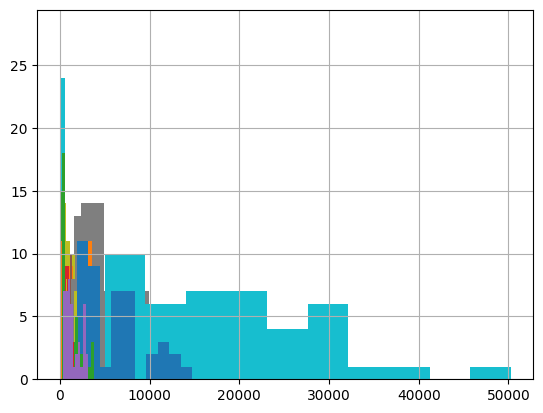

In [97]:
i =2
# print(gov[1])
# pd.read_csv(gov[1], header =0).dropna()

print(gov[2])
df = pd.read_csv(gov[2], header =[0,1]).dropna()
# print(df.columns[:])
from matplotlib import pyplot as plt
for name in df.columns[:]:
    # set name to the column name you want to plot

    df[name].hist()


In [19]:
df.isna().sum()


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [26]:
df = df.dropna()
df


,Unnamed: 0,Unnamed: 1,Estimate,Estimate.1,Estimate.2,Estimate.3,Estimate.4,Estimate.5,Estimate.6,Estimate.7,Number of agricultural businesses,Number of agricultural businesses.1,Number of agricultural businesses.2,Number of agricultural businesses.3,Number of agricultural businesses.4,Number of agricultural businesses.5,Number of agricultural businesses.6,Number of agricultural businesses.7
5,Adelaide - Central and Hills,2012,62194.2,11584.4,18498.8,3875.8,2078.0,3.2,5192.2,18498.8,795.0,477.0,786.0,414.0,36.0,0.0,414.0,786.0
6,Adelaide - Central and Hills,2013,55944.21,11596.94,20319.02,6748.18,1136.24,2.85,6716.88,19127.68,894.0,497.0,797.0,488.0,110.0,0.0,450.0,450.0
7,Adelaide - Central and Hills,2014,59636.8,13257.0,25435.88,8926.66,2575.09,3.44,6886.61,23690.3,784.0,557.0,767.0,448.0,116.0,0.0,478.0,478.0
8,Adelaide - Central and Hills,2015,84277.59,11653.42,16342.25,2779.75,814.13,3.23,4710.6,15202.21,415.0,281.0,401.0,203.0,61.0,0.0,260.0,260.0
9,Adelaide - Central and Hills,2016,45380.13,10159.41,14530.29,3364.41,403.28,2.59,5200.12,13482.05,434.0,298.0,408.0,237.0,25.0,0.0,279.0,279.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,Yarramundi - Londonderry,2020,1734.53,1.4,929.9,21.46,896.07,7.81,119.01,929.9,30.0,1.0,13.0,7.0,5.0,0.0,13.0,13.0
2003,Yass Surrounds,2020,353092.49,257.36,1429.32,266.97,904.99,2.56,564.69,1446.26,483.0,23.0,35.0,16.0,5.0,0.0,35.0,35.0
2004,Yea,2020,91341.8,318.11,2905.9,550.93,732.95,1.71,1698.11,2903.55,145.0,4.0,21.0,12.0,7.0,0.0,21.0,21.0
2010,Young,2020,49142.32,497.1,707.18,186.12,23.23,0.76,964.86,737.25,101.0,19.0,21.0,5.0,1.0,0.0,21.0,21.0


In [29]:
df.dtypes


Unnamed: 0                             object
Unnamed: 1                             object
Estimate                               object
Estimate.1                             object
Estimate.2                             object
Estimate.3                             object
Estimate.4                             object
Estimate.5                             object
Estimate.6                             object
Estimate.7                             object
Number of agricultural businesses      object
Number of agricultural businesses.1    object
Number of agricultural businesses.2    object
Number of agricultural businesses.3    object
Number of agricultural businesses.4    object
Number of agricultural businesses.5    object
Number of agricultural businesses.6    object
Number of agricultural businesses.7    object
dtype: object

In [13]:

import pandas as pd

# first row is header
lng_df = pd.read_csv('Governance/Copy of agriculture_australian_economy.csv', header=1)
lng_df.head()


,Activity 2,Percent change from previous period,Imports,Exports,Current account balance,Net foreign debt level,Net foreign debt share of GDP,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,Location,Australia,Australia,Australia,Australia,Australia,Australia,Australia,United States of America,European Union,Japan,Organisation for Economic Cooperation and Deve...,China,Republic of Korea
1,Measure,Rate,Value,Value,Value,Value,Rate,Rate,Rate,Rate,Rate,Rate,Rate,Rate
2,Unit,%,$m,$m,$m,$m,%,%,%,%,%,%,%,%
3,1974,1.30,"10,160.00","10,160.00",-959.00,NaN,NaN,1.76,-0.50,NaN,-1.20,0.49,2.30,9.40
4,1975,2.60,"11,253.00","11,253.00","-1,131.00","3,133.00",NaN,2.51,-0.20,NaN,3.10,0.18,8.70,7.30


In [52]:
import pandas as pd

pd.read_csv("Governance/agriculture_australian_economy.csv", header= [0,1,2])


FileNotFoundError: [Errno 2] No such file or directory: 'Governance/agriculture_australian_economy.csv'